In [1]:
import pandas as pd, numpy as np, gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler


import gc
import cudf
import cupy

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reduce Memory Usag[e
def reduce_memory_usage(df, categ = True):
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                if categ:
                    df[col] = df[col].astype('category')
    
    return df

#Plot the Features Importances
def plotImp(model, X , num = 20, fig_size = (8, 6)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
#     sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    sns.set()

In [3]:
print('read..')
train = pd.read_parquet('/kaggle/input/performace-student-2/train.parquet')
print('reduce memory..')
train = reduce_memory_usage(train, categ = False)
targets = pd.read_csv('/kaggle/input/performace-student-2/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
# conver train to GPU usage
print('cudf..')
train = cudf.from_pandas(train)


read..
reduce memory..
cudf..


In [5]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',  
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']
name = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

In [6]:
def time(train):
    print('time')
    train['session_id']= train.index
    train["year"] = train['session_id'].astype(str).str[:2].astype(int)
    train["month"] = train['session_id'].astype(str).str[2:4].astype(int)+1
    train["day"] = train['session_id'].astype(str).str[4:6].astype(int)
    train["hour"] = train['session_id'].astype(str).str[6:8].astype(int)
    train["minute"] = train['session_id'].astype(str).str[8:10].astype(int)
    train["second"] = train['session_id'].astype(str).str[10:12].astype(int)
    train = train.drop('session_id',axis=1)
    return train

In [8]:
def feature_engineer(train):
    train = train.sort_values(by=['session_id', 'elapsed_time'])
    dfs = []
    
    print('NAME..')
    for c in name: 
        train[c] = (train.name == c).astype('int8')
    for c in name :
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train.drop(name,axis=1,inplace=True)
               
    print('count..')
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('count')
        tmp.name = tmp.name + '_count'
        dfs.append(tmp)
        
#     train["year"] = train['session_id'].astype(str).str[:2].astype(int)
#     train["month"] = train['session_id'].astype(str).str[2:4].astype(int)+1
#     train["day"] = train['session_id'].astype(str).str[4:6].astype(int)
#     train["hour"] = train['session_id'].astype(str).str[6:8].astype(int)
#     train["minute"] = train['session_id'].astype(str).str[8:10].astype(int)
#     train["second"] = train['session_id'].astype(str).str[10:12].astype(int)
#     NUMS += (['year','month','day','hour','minute','second'])

    print('D_TIME..')
    train['d_time'] = train['elapsed_time'].diff(1)
    train['d_time'].fillna(0, inplace=True)
    train['delt_time'] = train['d_time'].clip(0, 103000)
    train['delt_time_next'] = train['delt_time'].shift(-1)
    
   
    tmp = train.groupby(['session_id','level_group'])['d_time'].quantile(q=0.15)
    tmp.name = 'tmp1_0_15'
    dfs.append(tmp)

    tmp = train.groupby(['session_id','level_group'])['d_time'].quantile(q=0.3)
    tmp.name = 'tmp1_0_3'
    dfs.append(tmp)

    tmp = train.groupby(['session_id','level_group'])['d_time'].quantile(q=0.8)
    tmp.name = 'tmp2_0_8'
    dfs.append(tmp)

    tmp = train.groupby(['session_id','level_group'])['d_time'].quantile(q=0.5)
    tmp.name = 'tmp3_0_5'
    dfs.append(tmp)

    tmp = train.groupby(['session_id','level_group'])['d_time'].quantile(q=0.65)
    tmp.name = 'tmp4_0_65'
    dfs.append(tmp)
    
    tmp = train.groupby(['session_id','level_group'])['d_time'].quantile(q=0.75)
    tmp.name = 'tmp4_0_75'
    dfs.append(tmp)
    
    tmp = train.groupby(['session_id','level_group'])['d_time'].quantile(q=0.90)
    tmp.name = 'tmp4_0_90'
    dfs.append(tmp)
    
    print('feature engineering..')
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)    
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
        tmp = train.groupby(['session_id','level_group'])[c].agg('count')
        tmp.name = tmp.name + '_count'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + ' sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
    
    print('feauter interation..')
    for i in dfs:
        if i.name =='room_fqid_count':
            for j in dfs:
                if j.name == 'fqid_count':
                    tmp = i+j; tmp.name = 'room_Add_fqid'; dfs.append(tmp)
                    tmp = i-j; tmp.name = 'room_Subtration_fqid'; dfs.append(tmp)
                    tmp = i*j; tmp.name = 'room_Multiblicaiton_fqid'; dfs.append(tmp)
                    tmp = i/(j+1); tmp.name = 'room_Divition_fqid'; dfs.append(tmp)
        if i.name =='elapsed_time_mean':
            for j in dfs:
                if j.name == 'index_mean':
                    tmp = i/(j+1); tmp.name = 'elapsed_time_Divition_index'; dfs.append(tmp)
                    tmp = i*j ; tmp.name = 'elapsed_Multi_index'; dfs.append(tmp)
                elif j.name == 'level_mean':
                    tmp = i/(j+1); tmp.name = 'elapsed_time_Divition_level'; dfs.append(tmp)
                    tmp = i*j ; tmp.name = 'elapsed_Multi_level'; dfs.append(tmp)   
    
    print('Bingo Feature')
    tmp = train[(train['fqid']=='logbook.page.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['index'].agg('first') - train[train['fqid']=='logbook'].groupby(['session_id','level_group'])['index'].agg('first')
    tmp.name = 'logbingo-logbook'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='reader.paper2.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['index'].agg('first') - train[train['fqid']=='reader'].groupby(['session_id','level_group'])['index'].agg('first')
    tmp.name = 'readerbingo-reader'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='journals.pic_2.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['index'].agg('first') - train[train['fqid']=='journals.pic_0.next'].groupby(['session_id','level_group'])['index'].agg('first')
    tmp.name = 'jourbingo-journalspic'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='logbook.page.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['elapsed_time'].agg('first') - train[train['fqid']=='logbook'].groupby(['session_id','level_group'])['elapsed_time'].agg('first')
    tmp.name = 'logbingo-logbook_time'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='reader.paper2.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['elapsed_time'].agg('first') - train[train['fqid']=='reader'].groupby(['session_id','level_group'])['elapsed_time'].agg('first')
    tmp.name = 'readerbingo-reader_time'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='journals.pic_2.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['elapsed_time'].agg('first') - train[train['fqid']=='journals.pic_0.next'].groupby(['session_id','level_group'])['elapsed_time'].agg('first')
    tmp.name = 'jourbingo-journalspic_time'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='reader_flag.paper2.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['index'].agg('first') - train[train['fqid']=='reader_flag'].groupby(['session_id','level_group'])['index'].agg('first')
    tmp.name = 'readerbingo-reader_flag'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='journals_flag.pic_0.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['index'].agg('first') - train[train['fqid']=='journals_flag'].groupby(['session_id','level_group'])['index'].agg('first')
    tmp.name = 'journalbingo-journals_flag'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='reader_flag.paper2.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['elapsed_time'].agg('first') - train[train['fqid']=='reader_flag'].groupby(['session_id','level_group'])['elapsed_time'].agg('first')
    tmp.name = 'readerbingo-reader_flag_time'
    dfs.append(tmp)
    tmp = train[(train['fqid']=='journals_flag.pic_0.bingo')&(train['event_name']=='object_click')].groupby(['session_id','level_group'])['elapsed_time'].agg('first') - train[train['fqid']=='journals_flag'].groupby(['session_id','level_group'])['elapsed_time'].agg('first')
    tmp.name = 'journalbingo-journals_flag_time'
    dfs.append(tmp)


    gc.collect()
    df = cudf.concat(dfs,axis=1)
    tmp = 0; dfs=0; x_t = 0; train=0
    del tmp, dfs, x_t, train
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    gc.collect()
    return df

In [10]:
df = feature_engineer(train)
df = time(df)
print( df.shape )
df.head()

NAME..
count..
D_TIME..
feature engineering..
feauter interation..
Bingo Feature
time
(70686, 86)


,level_group,basic_sum,undefined_sum,close_sum,open_sum,prev_sum,next_sum,event_name_count,fqid_count,room_fqid_count,text_count,tmp1_0_15,tmp1_0_3,tmp2_0_8,tmp3_0_5,tmp4_0_65,tmp4_0_75,tmp4_0_90,event_name_nunique,fqid_nunique,room_fqid_nunique,room_Multiblicaiton_fqid,room_Divition_fqid,elapsed_time_Divition_level,elapsed_Multi_level,logbingo-logbook,readerbingo-reader,jourbingo-journalspic,logbingo-logbook_time,readerbingo-reader_time,jourbingo-journalspic_time,readerbingo-reader_flag,journalbingo-journals_flag,readerbingo-reader_flag_time,journalbingo-journals_flag_time,year,month,day,hour,minute,second
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,74,85,6,0,0,0,165,104,165,62,477.00,601.0,1416.4,749.0,983.0,1233.00,2052.4,10,30,7,17160,1.571429,29127.442387,1.669075e+05,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,20,10,3,12,43,12
20090312431273200,13-22,228,187,5,0,0,0,420,313,420,196,449.85,593.8,1267.4,751.0,967.0,1166.75,1772.0,10,49,12,131460,1.337580,56547.072325,1.810893e+07,-1,-1,-1,-1,-1,-1,6,6,9881,5750,20,10,3,12,43,12
20090312431273200,5-12,161,129,6,0,0,0,296,235,296,126,450.00,585.0,1233.0,766.0,962.5,1114.25,1708.5,10,39,11,69560,1.254237,39452.513433,2.876950e+06,7,6,4,11175,7201,3644,-1,-1,-1,-1,20,10,3,12,43,12
20090312433251036,0-4,77,56,5,1,0,0,139,97,139,61,252.80,469.4,1819.8,818.0,1272.1,1630.00,3323.6,11,22,6,13483,1.418367,34012.644110,1.826237e+05,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,20,10,3,12,43,32
20090312433251036,13-22,504,733,39,19,1,1,1297,762,1297,229,366.00,550.8,1833.2,832.0,1151.4,1533.00,3050.0,11,73,16,988314,1.699869,133183.124430,4.438593e+07,-1,-1,11,-1,-1,5252,13,8,27818,5520,20,10,3,12,43,32


In [12]:
df = df.to_pandas()
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 85 features
We will train with 23562 users info


In [15]:
# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the MinMaxScaler to the training data
# scaler.fit(df[FEATURES])

# # Use the scaler to transform the training and test sets
# df_scaled = scaler.transform(df[FEATURES])
pd.concat(df_scaled,axis=1)

In [18]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
#     print('#'*25)
    print('Fold',i+1)
#     print('#'*25)
#     FEATURES = [c for c in df.columns if c not in ['level_group','previce_predict']]
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'gpu_hist',
        
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        if t ==1: FEATURES = [c for c in df.columns if c not in ['level_group','previce_predict']]
        else: FEATURES = [c for c in df.columns if c != 'level_group']

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        clf.save_model(f'{grp}_{t}.xgb')
        df['previce_predict'] =  clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

Fold 1
1(256), 2(110), 3(129), 4(217), 5(157), 6(107), 7(106), 8(80), 9(153), 10(71), 11(86), 12(163), 13(188), 14(421), 15(208), 16(92), 17(61), 18(244), 
Fold 2
1(186), 2(144), 3(92), 4(197), 5(147), 6(157), 7(76), 8(59), 9(174), 10(93), 11(168), 12(98), 13(100), 14(153), 15(141), 16(141), 17(133), 18(149), 
Fold 3
1(163), 2(130), 3(100), 4(240), 5(247), 6(81), 7(99), 8(58), 9(123), 10(106), 11(120), 12(90), 13(145), 14(271), 15(165), 16(125), 17(83), 18(136), 
Fold 4
1(239), 2(109), 3(85), 4(243), 5(215), 6(91), 7(98), 8(101), 9(131), 10(114), 11(79), 12(79), 13(211), 14(280), 15(150), 16(90), 17(75), 18(177), 
Fold 5
1(222), 2(145), 3(168), 4(221), 5(155), 6(133), 7(176), 8(115), 9(92), 10(63), 11(101), 12(157), 13(108), 14(219), 15(176), 16(62), 17(90), 18(197), 


0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

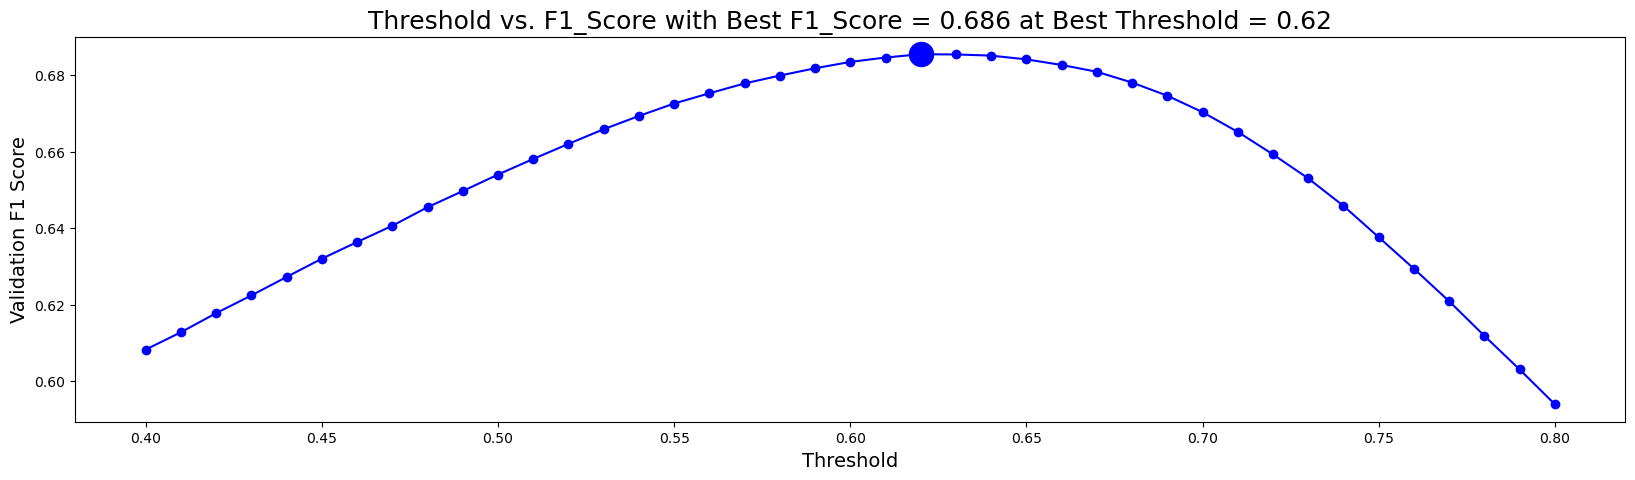

In [19]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values
    
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
        
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()        

In [20]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6062456815186807
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.4872099001874376
Q3: F1 = 0.6422801244237382
Q4: F1 = 0.6154630526070781
Q5: F1 = 0.6279482306758097
Q6: F1 = 0.6115065067738004
Q7: F1 = 0.5589556280319332
Q8: F1 = 0.6239182065143317
Q9: F1 = 0.5575617810356611
Q10: F1 = 0.6037101760874268
Q11: F1 = 0.5007245242759262
Q12: F1 = 0.46183625812774626
Q13: F1 = 0.6141140570709257
Q14: F1 = 0.5592881624226779
Q15: F1 = 0.47376482268363634
Q16: F1 = 0.5473369072021604
Q17: F1 = 0.49146016842543994
==> Overall F1 = 0.6855360526927232


In [22]:
# saved model
for key in models:
#     joblib.dump(models[key], f'{key}.pkl')
     models[key].save_model(f'{key}.xgb')

In [21]:
print('FEATURES = ',FEATURES,'\n')
# print('drop_this = ',final_columns_with_no_duplicate,'\n')
print('TSHRESHOLD = %2.2f'% best_threshold)

FEATURES =  ['basic_sum', 'undefined_sum', 'close_sum', 'open_sum', 'prev_sum', 'next_sum', 'event_name_count', 'fqid_count', 'room_fqid_count', 'text_count', 'tmp1_0_15', 'tmp1_0_3', 'tmp2_0_8', 'tmp3_0_5', 'tmp4_0_65', 'tmp4_0_75', 'tmp4_0_90', 'event_name_nunique', 'fqid_nunique', 'room_fqid_nunique', 'text_nunique', 'elapsed_time_sum', 'elapsed_time_mean', 'elapsed_time_std', 'elapsed_time_count', 'level_sum', 'level_mean', 'level_std', 'level_count', 'page_sum', 'page_mean', 'page_std', 'page_count', 'room_coor_x_sum', 'room_coor_x_mean', 'room_coor_x_std', 'room_coor_x_count', 'room_coor_y_sum', 'room_coor_y_mean', 'room_coor_y_std', 'room_coor_y_count', 'screen_coor_x_sum', 'screen_coor_x_mean', 'screen_coor_x_std', 'screen_coor_x_count', 'screen_coor_y_sum', 'screen_coor_y_mean', 'screen_coor_y_std', 'screen_coor_y_count', 'hover_duration_sum', 'hover_duration_mean', 'hover_duration_std', 'hover_duration_count', 'navigate_click sum', 'person_click sum', 'cutscene_click sum', 'o